In [ ]:
import pandas as pd
import utils
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import importlib
importlib.reload(utils)
from utils import grid_evaluate, preprocess_credit_card_data

# …then use pickle.dump / pickle.load as shown



#Load the saved CSVs
X_train = pd.read_csv('X_train.csv')
X_validation = pd.read_csv('X_validation.csv')
y_train = pd.read_csv('y_train.csv')
y_validation = pd.read_csv('y_validation.csv')

#Squeeze to make them series
y_train = y_train.squeeze()
y_validation = y_validation.squeeze()

#Verify shapes
print(X_train.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_validation.shape)


(747, 28)
(250, 28)
(747,)
(250,)


In [45]:
base_clf = LogisticRegression(max_iter=5000)

#Parameters to be tried together
param_grid = {
    'feature_method': [None, 'polynomial', 'pca', 'rbf'],
    'degree':         [2, 3],
    'n_components':   [5, 10],
    'gamma':          [0.1, 0.5],   
    'C':              [0.001,0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty':        ['l2'], 
    'random_state': [42]
}

results, best_model = grid_evaluate(
    estimator  = base_clf,
    param_grid = param_grid,
    X_train    = X_train,
    X_validation     = X_validation,
    y_train    = y_train,
    y_validation     = y_validation
)


#drop unnecessary columns (neural network columns)
results = results.drop(
    columns=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    errors='ignore'   # won’t error out if any are already missing
)

# best by F1
results = results.sort_values('f1_validation', ascending=False)

print(results)
print(results.iloc[0])




Evaluated 5 parameter combinations...
Evaluated 10 parameter combinations...
Evaluated 15 parameter combinations...
Evaluated 20 parameter combinations...
Evaluated 25 parameter combinations...
Evaluated 30 parameter combinations...
Evaluated 35 parameter combinations...
Evaluated 40 parameter combinations...
Evaluated 45 parameter combinations...
Evaluated 50 parameter combinations...
Evaluated 55 parameter combinations...
Evaluated 60 parameter combinations...
Evaluated 65 parameter combinations...
Evaluated 70 parameter combinations...
Evaluated 75 parameter combinations...
Evaluated 80 parameter combinations...
Evaluated 85 parameter combinations...
Evaluated 90 parameter combinations...
Evaluated 95 parameter combinations...
Evaluated 100 parameter combinations...
Evaluated 105 parameter combinations...
Evaluated 110 parameter combinations...
Evaluated 115 parameter combinations...
Evaluated 120 parameter combinations...
Evaluated 125 parameter combinations...
Evaluated 130 parame

In [46]:
results.to_csv('logistic_regression_results.csv', index=False)
print("Saved results to logistic_regression_results.csv")

print(results.columns.tolist())


Saved results to logistic_regression_results.csv
['feature_method', 'degree', 'n_components', 'gamma', 'accuracy_validation', 'accuracy_train', 'precision_validation', 'recall_validation', 'f1_validation', 'precision_train', 'recall_train', 'f1_train', 'C', 'penalty', 'random_state']


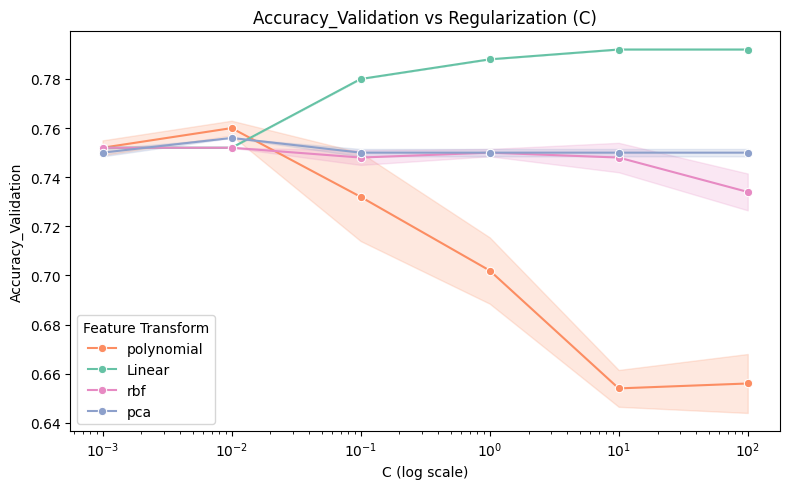

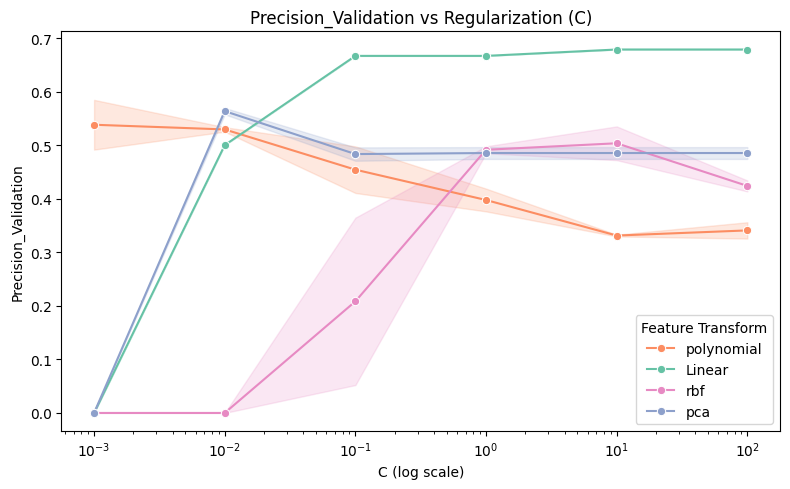

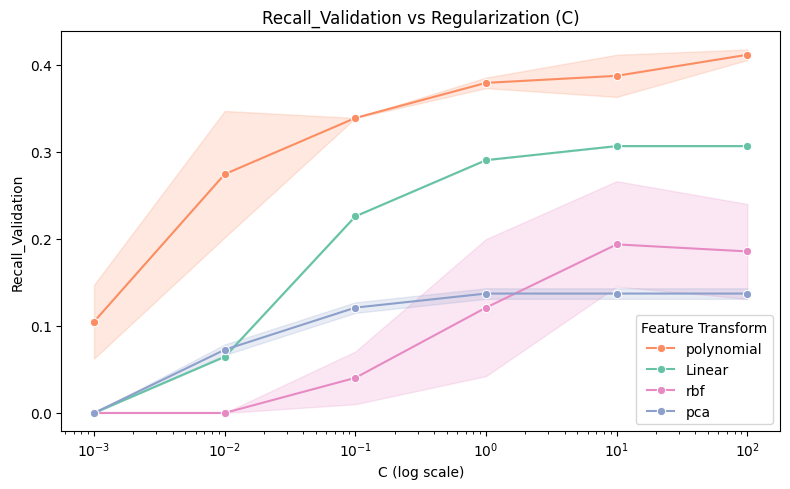

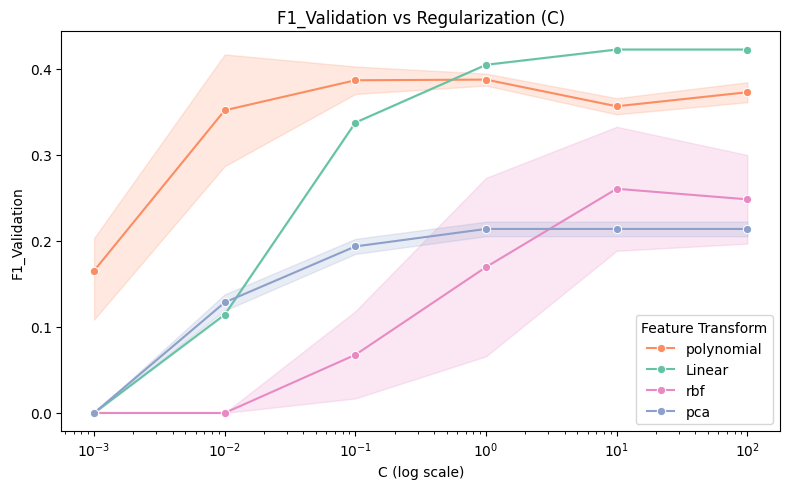

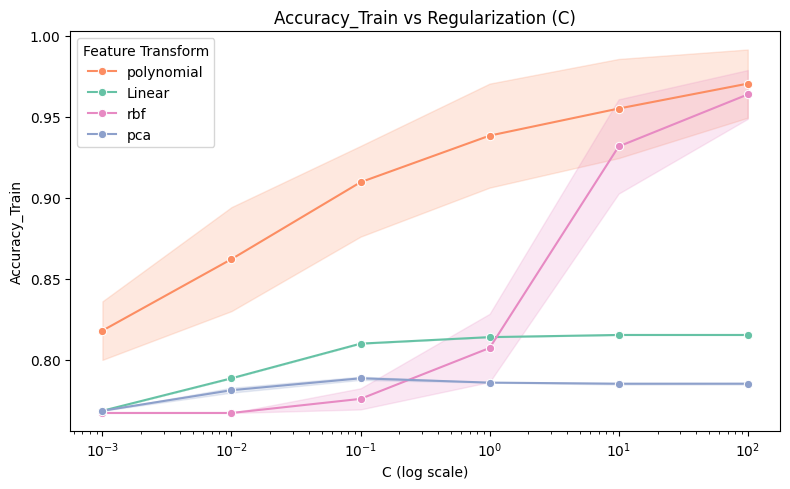

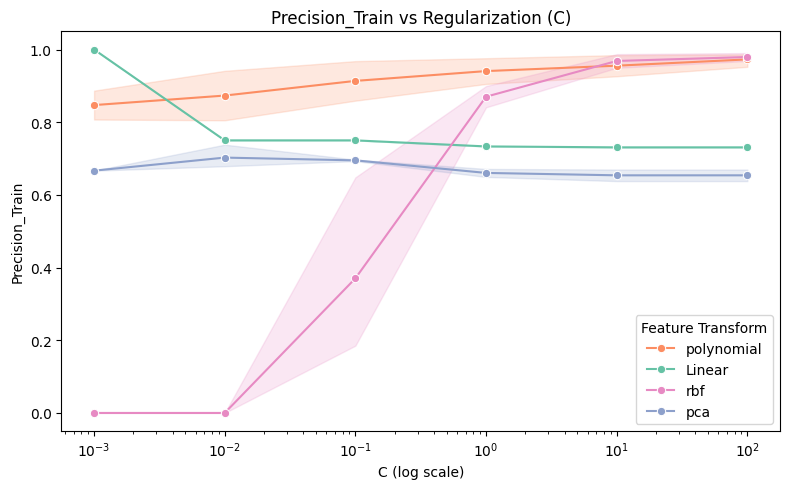

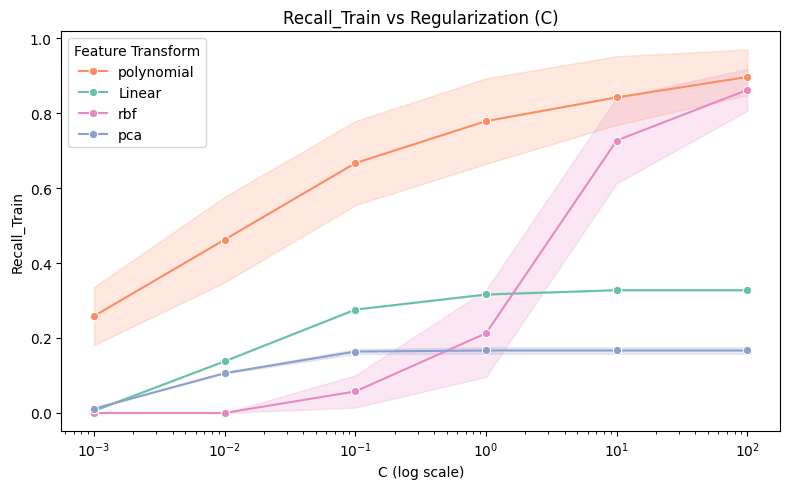

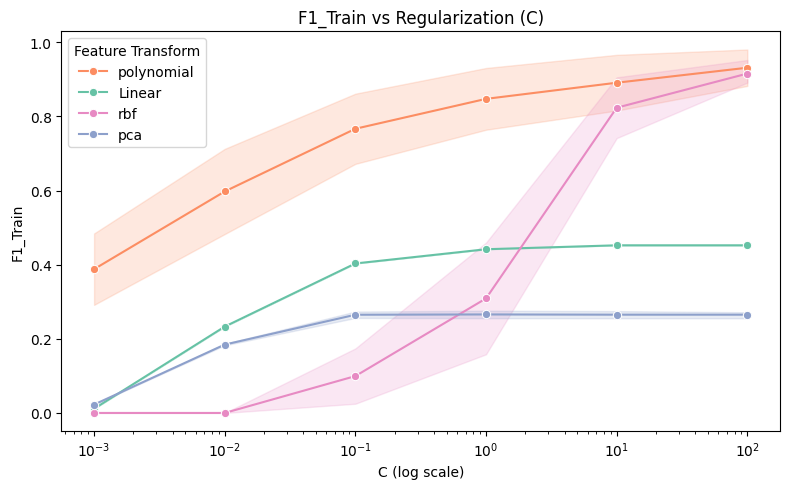

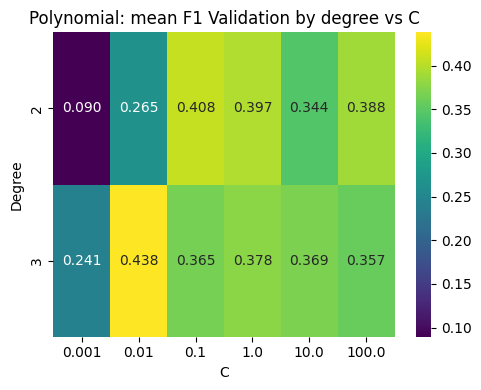

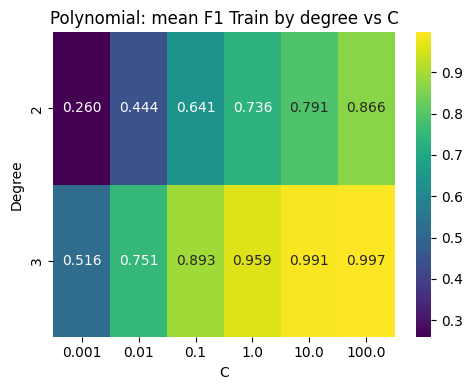

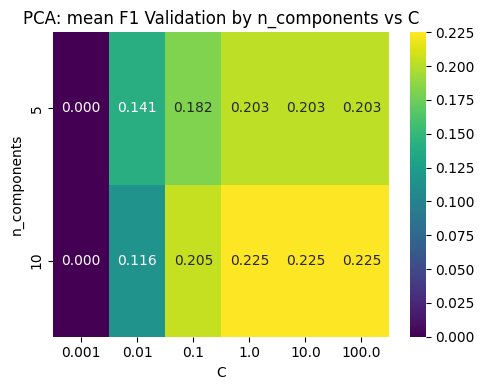

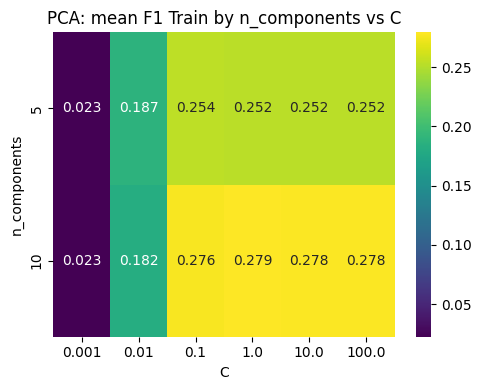

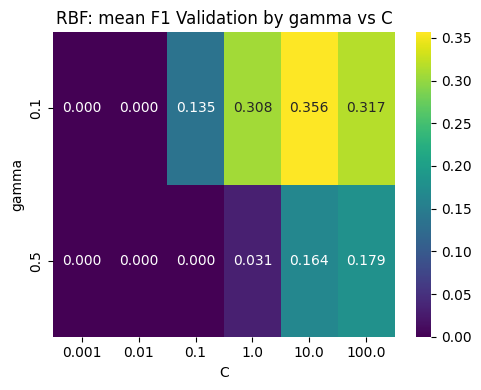

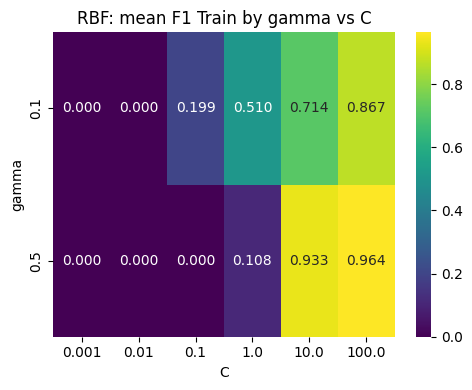

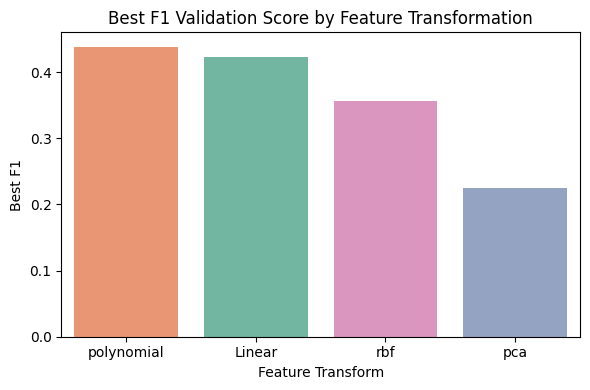

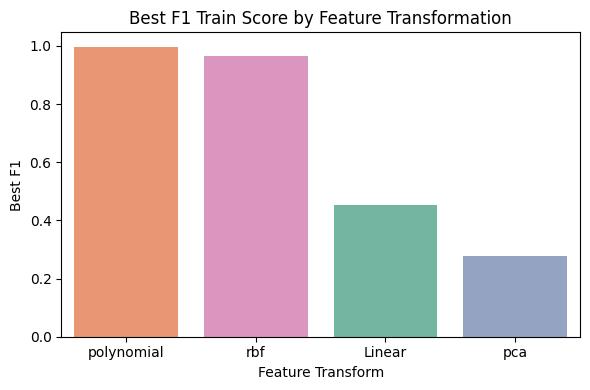

In [47]:
methods = ['Linear','polynomial','pca','rbf']
colors  = sns.color_palette("Set2", n_colors=len(methods))  # or any palette you like
fixed_palette = dict(zip(methods, colors))

#Line‐plots of each metric vs C (unchanged)


metrics = [
    'accuracy_validation',
    'precision_validation',
    'recall_validation',
    'f1_validation',
    'accuracy_train',
    'precision_train',
    'recall_train',
    'f1_train',
]

for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data   = results,
        x      = 'C',
        y      = metric,
        hue    = 'feature_method',
        palette = fixed_palette,
        marker = 'o'
    )
    plt.xscale('log')
    plt.title(f'{metric.title()} vs Regularization (C)')
    plt.ylabel(metric.title())
    plt.xlabel('C (log scale)')
    plt.legend(title='Feature Transform')
    plt.tight_layout()
    plt.show()


#Heatmap for Polynomial: mean F1 by degree vs C
poly = results[results['feature_method']=='polynomial']
if not poly.empty:
    pivot_poly = poly.pivot_table(
        index='degree',
        columns='C',
        values='f1_validation',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_poly, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('Polynomial: mean F1 Validation by degree vs C')
    plt.ylabel('Degree')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

poly = results[results['feature_method']=='polynomial']
if not poly.empty:
    pivot_poly = poly.pivot_table(
        index='degree',
        columns='C',
        values='f1_train',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_poly, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('Polynomial: mean F1 Train by degree vs C')
    plt.ylabel('Degree')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()


#Heatmap for PCA: mean F1 by n_components vs C
pca = results[results['feature_method']=='pca']
if not pca.empty:
    pivot_pca = pca.pivot_table(
        index='n_components',
        columns='C',
        values='f1_validation',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_pca, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('PCA: mean F1 Validation by n_components vs C')
    plt.ylabel('n_components')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

pca = results[results['feature_method']=='pca']
if not pca.empty:
    pivot_pca = pca.pivot_table(
        index='n_components',
        columns='C',
        values='f1_train',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_pca, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('PCA: mean F1 Train by n_components vs C')
    plt.ylabel('n_components')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

#Heatmap for RBF: mean F1 by gamma vs C
rbf = results[results['feature_method']=='rbf']
if not rbf.empty:
    pivot_rbf = rbf.pivot_table(
        index='gamma',
        columns='C',
        values='f1_validation',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_rbf, annot=True, fmt='.3f', cmap='viridis', )
    plt.title('RBF: mean F1 Validation by gamma vs C')
    plt.ylabel('gamma')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

rbf = results[results['feature_method']=='rbf']
if not rbf.empty:
    pivot_rbf = rbf.pivot_table(
        index='gamma',
        columns='C',
        values='f1_train',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_rbf, annot=True, fmt='.3f', cmap='viridis',)
    plt.title('RBF: mean F1 Train by gamma vs C')
    plt.ylabel('gamma')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()

#test
best_per = (
    results
    .groupby('feature_method', as_index=False)
    ['f1_validation']
    .max()
    .sort_values('f1_validation', ascending=False)
)

plt.figure(figsize=(6,4))
ax = sns.barplot(
    data    = best_per,
    x       = 'feature_method',
    y       = 'f1_validation',
    hue     = 'feature_method',  
    dodge   = False,              
    palette = fixed_palette,
)
legend = ax.get_legend()
if legend is not None:
    legend.remove()


plt.title('Best F1 Validation Score by Feature Transformation')
plt.ylabel('Best F1')
plt.xlabel('Feature Transform')
plt.tight_layout()
plt.show()


#train
best_per = (
    results
    .groupby('feature_method', as_index=False)
    ['f1_train']
    .max()
    .sort_values('f1_train', ascending=False)
)

plt.figure(figsize=(6,4))
ax = sns.barplot(
    data    = best_per,
    x       = 'feature_method',
    y       = 'f1_train',
    hue     = 'feature_method',  
    dodge   = False,              
    palette = fixed_palette,
)
legend = ax.get_legend()
if legend is not None:
    legend.remove()


plt.title('Best F1 Train Score by Feature Transformation')
plt.ylabel('Best F1')
plt.xlabel('Feature Transform')
plt.tight_layout()
plt.show()


In [48]:
best_logistic = results.nlargest(1, 'f1_validation')
print(best_logistic)


   feature_method  degree  n_components  gamma  accuracy_validation  \
55     polynomial       3            10    0.5                0.764   

    accuracy_train  precision_validation  recall_validation  f1_validation  \
55        0.904953              0.534884           0.370968       0.438095   

    precision_train  recall_train  f1_train     C penalty  random_state  
55         0.963964      0.614943  0.750877  0.01      l2            42  


In [ ]:
print(best_model)
best_model



LogisticRegression(C=0.01, max_iter=5000, random_state=42)


In [53]:
test_df = pd.read_pickle('test_df.pkl')
test_df = preprocess_credit_card_data(test_df)
X_test = test_df.drop(columns=['default.payment.next.month'])
y_test = test_df['default.payment.next.month']
print(test_df.head())



   LIMIT_BAL  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0   100000.0   43      1     -2     -2     -2     -1      0        0.0   
1   290000.0   38      0      0      0      0      0      0   118801.0   
2   110000.0   48      0      0      0      0      0      0    92806.0   
3   170000.0   44      0      0      0      0      0     -1   150692.0   
4   120000.0   59      2      2      2      2      2      2    82172.0   

   BILL_AMT2  ...  SEX_1  SEX_2  EDUCATION_1  EDUCATION_2  EDUCATION_3  \
0        0.0  ...      1      0            0            1            0   
1    99370.0  ...      1      0            0            1            0   
2    91217.0  ...      1      0            0            1            0   
3   152861.0  ...      0      1            0            0            1   
4    80266.0  ...      0      1            0            1            0   

   EDUCATION_4  EDUCATION_5  MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  
0            0            0           1     

c:\Users\Vai.Mathi\Downloads\ML-Final-Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: X has 30 features, but LogisticRegression is expecting 4494 features as input.